# Simulating GMB paths
See Binomial Trees notebook for definition of GBM and
$$
S_{t}=S_{0} \operatorname{e x p} \biggl( \left( \mu-{\frac{\sigma^{2}} {2}} \right) t+\sigma W_{t} \biggr). 
$$
$W_{t}$ at different time points can be simulated by definition by adding independent Gaussians.

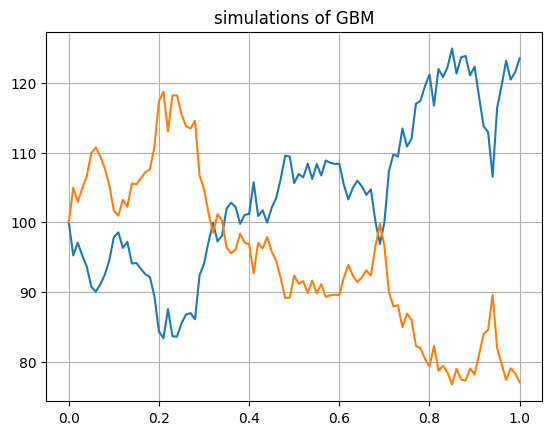

In [8]:
import numpy as np
def simulate_GBM_path(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.insert(W, 0, 0, axis=1)
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

def simulate_GBM_path_anti(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.insert(W, 0, 0, axis=1)
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    W_anti = -W ### antithetic brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    X_anti = (mu - 0.5*sigma**2)*t + sigma*W_anti
    S = S0*np.exp(X) ### geometric brownian motion
    S_anti = S0*np.exp(X_anti) ### antithetic geometric brownian motion
    return np.concatenate((S, S_anti), axis=0)

import matplotlib.pyplot as plt
from parameters import parameters_default

# Example usage
np.random.seed(41)
par = parameters_default()
par.num_paths = 1
paths = simulate_GBM_path(par.S0, par.r, par.sigma, par.T, par.dt, par.num_paths)
paths_anti = simulate_GBM_path_anti(par.S0, par.r, par.sigma, par.T, par.dt, par.num_paths)

# Plot the simulated geometric Brownian motion paths
for i in range(paths_anti.shape[0]):
    plt.plot(np.linspace(0,par.T,round(par.T/par.dt)+1),paths_anti[i, :])
    plt.grid(True)
    plt.title("simulations of GBM")
plt.show()


# Least-Square Monte Carlo

Longstaff-Schwarz is commonly used approach to price American options. The principles behind the approach are:

- Replacing the actual dynamics with samples paths, i.e., an empirical path distribution. This gives 
least square MC the flexibility to work with any generative model but storing all paths may lead to memory problems.

- Approximating the continuation rule through dynamic programming and estimating the 
needed conditional expected payoff with OLS. 

- Only use the conditional expected payoff to approximate the continuation rule such that 
in every step the value estimate is unbiased for the value for the current  continuation 
rule after this point which is a lower bound on the best possible achievable value after this point. 

As the sample paths increase, the actual dynamics are better captured and the value for 
the current continuation rules can be better estimated. To get a better 
continuation rule both the more samples and more model complexity are needed for the OLS.  

In [11]:
from sklearn.linear_model import LinearRegression

def payoff_put(S,K): return np.maximum(K-S,0)

def least_square_Monte_Carlo_put(paths,r,dt,T,K):
    value = payoff_put(paths[:,-1],K)
    for col in paths.T[:-1][::-1]:# stepping backwards in time
       value *= np.exp(-r*dt) # discounting 
       ITMmask = col < K # selects paths ITM
       ITMpaths = col[ITMmask]
       ITMvalue = value[ITMmask]
       model = LinearRegression()
       X = np.column_stack((ITMpaths,ITMpaths**2))
       model.fit(X,ITMvalue) # OLS of the continuation value
       interpolated = model.predict(X)
       exercised = payoff_put(ITMpaths,K)
       value[ITMmask] = np.where(interpolated>exercised, ITMvalue, exercised)
    return np.mean(value), np.std(value)/np.sqrt(len(value))

def LSMC_put(par):
    paths = simulate_GBM_path_anti(par.S0, par.mu, par.sigma, par.T, par.dt, par.num_paths)
    return least_square_Monte_Carlo_put(paths,par.r,par.dt,par.T,par.K)

from parameters import parameters_default

np.random.seed(42)
par = parameters_default()
val, std = LSMC_put(par) 
print(val, std)

15.10941585408107 0.03998489895464419
